# Testing the mount and display figure

In [ ]:
# old way to mount drive
# from google.colab import drive 
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ 2/images

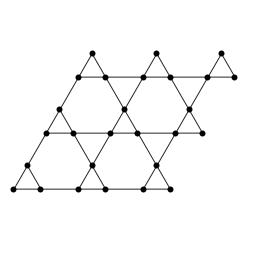

(256, 256)

In [ ]:
import os
path = '/content/drive/My Drive/Colab Notebooks/Capstone 2/images/'
#for filename in os.listdir(path):
#  print(filename)

from keras.preprocessing.image import *
import numpy as np 
figure = load_img(path + '0wb.jpg')
pixels = img_to_array(figure)

display(figure)
figure.size

# INITIALIZATION - LOAD AND UNLOAD FIGURES

In [ ]:
import os
from keras.preprocessing.image import *
import numpy as np 
import matplotlib.pyplot as plt

Load the images from Google Drive into numpy arrays:
- iob_list is the list of images withOut Bonds (sources)
- iwb_list is the list of images With Bonds (targets)

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Capstone 2/images/'

def load_images(path, size=(256,256)):
  iwb_list, iob_list = list(), list()
  for filename in sorted(os.listdir(path)):
	  # load and resize the image and convert to numpy array
    pixels = load_img(path + filename, target_size=size)
    pixels = img_to_array(pixels)
		# append to list of images with/without bonds
    if filename[-6:-4] == 'wb':
      iwb_list.append(pixels)
    elif filename[-6:-4] == 'wo':
      iob_list.append(pixels)
  return [np.asarray(iob_list), np.asarray(iwb_list)]

Save those loaded images in a compress file called figs.npz

In [ ]:
[ob_pixels, wb_pixels] = load_images(path)
print('Loaded: ', ob_pixels.shape, wb_pixels.shape)
np.savez_compressed('figs.npz', ob_pixels, wb_pixels)

Loaded:  (90, 256, 256, 3) (90, 256, 256, 3)


Display the images as pairs by reloading the dataset

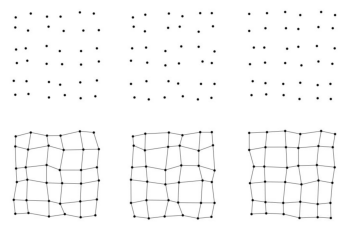

In [ ]:
data = np.load('figs.npz')
iob_list, iwb_list = data['arr_0'], data['arr_1']
# plot two pairs of images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(iob_list[i+50].astype('uint8'))
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(iwb_list[i+50].astype('uint8'))
plt.show()

# plot only one image
# plt.subplot(1,2,1)
# plt.imshow(iob_list[0].astype('uint8'))
# plt.subplot(1,2,2)
# plt.imshow(iwb_list[0].astype('uint8'))
# plt.show()

# BUILDING THE DISCRIMINATOR

In [ ]:
from keras.initializers import RandomNormal
from keras.models import Model, Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, BatchNormalization, Concatenate, Dropout
from keras.optimizers import Adam

Let's start by building the discriminator. 

The discriminator is a model that will eventually take an image shape and performs **conditional-image** classification. In summary, it takes the source image (w/o bonds) and the target image (w bonds) and classify if the the target is the *real translation* of the source. In detail, it :
- creates source/target inputs with same shape as image_shape
- merges source/target by concatenation so that the input of the deep convulational neural network has dimensions 256*256 and 6 channels (3 for each source/target)
- takes the merged input and makes it go through the CNN
- compiles the output to create a model



In [ ]:
def define_discriminator(image_shape):
	# weight initialization, source and target inputs and merge them
	init = RandomNormal(stddev=0.02)
	in_source_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_source_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define and compile model
	model = Model([in_source_image, in_target_image], patch_out)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

image_shape = data['arr_0'].shape[1:]
m = define_discriminator(image_shape)
# m.summary()

The deep CNN consists of:
- 1 layer with **64 filters** each of size (4,4) and strides (2,2). This means the input of the first layer is ?, 256,256,6 and the output is ?, 128, 128, 64 (where ? corresponds to the number of input images)
- then, 1 layer with **128 filters**, same size and same stride. The output is then ?,64,64,128
- then, 1  layer with **256 filters**, same size and same stride. The output is then ?,32,32,256
- then, 1  layer with **512 filters**, same size and same stride. The output is then ?,16,16,512
- then, another layer with **512 filters**, same size and same stride. The output is then ?,16,16,512
- finally, 1 layer to reduce the output to ?, 16, 16 and **1 channel** which is then activated via *sigmoid*.

The layers are connected by *Batch Normalization*, *ReLU function* in order to keep our channels **normalized**. 

Each layer of the CNN takes as arguments '*same padding*' in order to avoid any discrepency with the pixels on the borders. The weights of each layer are initially randomly distributed around 0. The key feature is that the weights update for the discriminator needs to be slow compared to the generator, hence the use of *binary cross entropy* with a weighting of *loss_weights=0.5* to be twice as slow. 

# BUILDING THE GENERATOR

The generator consists of an **encoder section** and a **decoder section**. Each encoder is truly a CNN and is similar to the layers of the discriminator in that it reduces the input images but increases the number of channels. Meanwhile, the decoder expands the input images and takes as input both the output of the previous layer and the **output of corresponding contracting block**. This ensures the features learned during the encoding phase are re-used to reconstruct the image in the decoding one.

In [ ]:
def encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides =(2,2), padding='same', kernel_initializer=init)(layer_in)
	# Batch normalization and ReLU functions
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with output of corresponding contracting block
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# in_image = Input(shape=image_shape)
# out_image = encoder_block(in_image, 64, batchnorm=False)
# out_image

And we now build the **generator**. It consists of 7 encoding blocks, which reduces the image from (256,256,3) to (128,128,64) to (64,64,128) to (32,32,256) to (16,16,512) to (8,8,512) to (4,4,512) and finally to (2,2,512).

The **bottle neck** section reduces the image to (1,1,512).

The **decoder** then:
- expands it back to (2,2,512) and concatenate with the corresponding encoder output image to produce a (2,2,1024) image. 
- The next decoder returns a (4,4,512) before concatenating with the corresponding encoder ouput image and to produce a (4,4,1024)
- And so on to produce (8,8,512) and (8,8,1024),
- then (16,16,512) and (16,16,1024),
- then (32,32,256) and (32,32,512),
- then (64,64,128) and (64,64,256),
- and finally (128,128,64) and (128,128,64)

The output layer consists of reducing the channels to 3 with images of size(256,256) identical to those that were fed to the generator.




In [ ]:
def define_generator(image_shape=(256,256,3)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = encoder_block(in_image, 64, batchnorm=False)
	e2 = encoder_block(e1, 128)
	e3 = encoder_block(e2, 256)
	e4 = encoder_block(e3, 512)
	e5 = encoder_block(e4, 512)
	e6 = encoder_block(e5, 512)
	e7 = encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output and model
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	model = Model(in_image, out_image)
	return model

# m = define_generator(image_shape)
# m.summary()

The **Generative Adverserial Network (GAN)** is a *composite model* which consists of both discriminator and generator at once. While the generator updates its weigths via the discriminator, the discriminator isn't trained and updates its weights "*on its own*". Note, the updates for the composite model are done with respect to two targets:
- the output of the discriminator (to find if the generated images are real). This is done via cross entropy loss (*'binary_crossentropy'*) and forces large weight updates to the generator
- the executed real translation of the image compared to the generated one (L1 Loss)


In [ ]:
def define_gan(g_model, d_model, image_shape):
	in_source = Input(shape=image_shape)
	# discriminator not trainable
	d_model.trainable = False
	# generate image from in_source
	gen_out = g_model(in_source)
	# pass both in_source and gen_out to discriminator
	dis_out = d_model([in_source, gen_out])
	# build and compile a model where source is input and classification and generated image are outputs
	model = Model(in_source, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# MORE FUNCTIONS

A function that load thes images from the compressed file (figs.npz) and that converts the RGB channel from [0 to 255] to [-1,1]

In [ ]:
def load_real_samples(filename):
	data = np.load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

A function which generates real samples: a source image drawn at random and a target image drawn at random, both from the dataset. The function returns the two images mentioned and the prediction vector : a bunch 2D arrays of 1's where each array has size identical to the output of the discriminator, i.e. the size of the original images (256*256)

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	# choose random images from dataset
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1,X2], y

# dataset = load_real_samples('figs.npz')
# g_model = define_generator(image_shape)
# [X1real,X2real], y_real  = generate_real_samples(dataset, 2, g_model.output_shape[1])

A function which generates fake samples, where we pick the source output images from generate_real_samples and return the generated image and a 2D array of 0's

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# dataset = load_real_samples('figs.npz')
# g_model = define_generator(image_shape)
# [X1real,X2real], y_real  = generate_real_samples(dataset, 2, g_model.output_shape[1])
# X1fake, y_fake = generate_fake_samples(define_generator(image_shape), X1real, g_model.output_shape[1])

A function that will allows us to evaluate the performance of the model through the iterations. In fact, at each step of the iterations:
- the plot of some samples (the source, the generated and the target) is saved to the file name: 'plot_'+step+1 + '.png'. For example: 
- the model is saved to the file name: 'model_'+step+1'.h5'. For example:

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=2):
	# select a sample of input images and its corresponding fake images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# subplot real source, generated and target images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# TRAINING THE DATA AND EXECUTING

For the training set we choose:
- a dataset of size 90 (30 images from each category)
- the number of patch (which is the size of each image and which should be equal to the output shape of the discriminator)
- the number of batches (3), meaning there are 30 images drawn at random in each batch per epoch
- 500 epochs; this means there are a total of 500*30 = 15000 steps

We summarize the performances every 300 iterations


In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=500, n_batch=3):
	# dataset
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	# the epochs, the batch per epoch and the total number of training iterations
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		# select a batch of real samples and update discriminator
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# generate a batch of fake samples and update discriminator
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator and summarize performance
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [ ]:
# the data
dataset = load_real_samples('figs.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
# the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

train(d_model, g_model, gan_model, dataset)

Loaded (90, 256, 256, 3) (90, 256, 256, 3)
>Saved: plot_000300.png and model_000300.h5
>Saved: plot_000600.png and model_000600.h5
>Saved: plot_000900.png and model_000900.h5
>Saved: plot_001200.png and model_001200.h5
>Saved: plot_001500.png and model_001500.h5
>Saved: plot_001800.png and model_001800.h5
>Saved: plot_002100.png and model_002100.h5
>Saved: plot_002400.png and model_002400.h5
>Saved: plot_002700.png and model_002700.h5
>Saved: plot_003000.png and model_003000.h5
>Saved: plot_003300.png and model_003300.h5
>Saved: plot_003600.png and model_003600.h5
>Saved: plot_003900.png and model_003900.h5
>Saved: plot_004200.png and model_004200.h5
>Saved: plot_004500.png and model_004500.h5
>Saved: plot_004800.png and model_004800.h5
>Saved: plot_005100.png and model_005100.h5
>Saved: plot_005400.png and model_005400.h5
>Saved: plot_005700.png and model_005700.h5
>Saved: plot_006000.png and model_006000.h5
>Saved: plot_006300.png and model_006300.h5
>Saved: plot_006600.png and model

In [ ]:
 model.save('/content/drive/My Drive/Colab Notebooks/Capstone 2/model3')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Capstone 2/model3/assets


# VERIFICATION

Let's now load a model and check what a generated picture from the training set looks like


Loaded (90, 256, 256, 3) (90, 256, 256, 3)


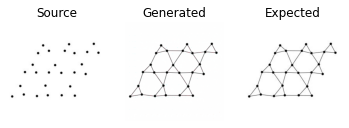

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


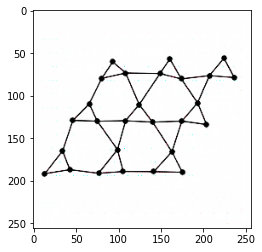

In [ ]:
from keras.models import load_model

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = np.vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	for i in range(len(images)):
		plt.subplot(1, 3, 1 + i)
		plt.axis('off')
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()

# load images and model
[X1, X2] = load_real_samples('figs.npz')
print('Loaded', X1.shape, X2.shape)
#model = load_model('model_015000.h5')
model = load_model('/content/drive/My Drive/Colab Notebooks/Capstone 2/model_015000.h5')

# select a random image from the set
ix = np.random.randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)
plot_images(src_image, gen_image, tar_image)

plt.imshow(gen_image[0])#.astype('uint8'))
plt.show()

Load it against an image from the testing data, one data is similar to the training data and one that is totally different

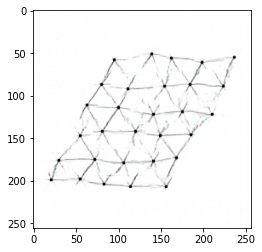

In [ ]:
def load_image(filename, size=(256,256)):
	pixels = load_img(filename, target_size=size)
	pixels = img_to_array(pixels)
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = np.expand_dims(pixels, 0)
	return pixels

# def plot_verif_images(src_imgs):
# 	for i in range(len(src_imgs)):
# 		gen_image = model.predict(src_imgs[i])
# 		gen_image = (gen_image + 1) / 2.0
# 		plt.subplot(1, 2, 1 + i)
# 		plt.axis('off')
# 		plt.imshow(gen_image[0])
# 	plt.show()

def plot_verif_image(src_img):
	gen_image = model.predict(src_img)
	gen_image = (gen_image + 1) / 2.0
	plt.imshow(gen_image[0])
	return plt.show()

# load images and model 
src_image_k = load_image(path+'testingk.png')
src_image_s = load_image(path+'testings.png')
src_image_t = load_image(path+'testingt.png')

plot_verif_image(src_image_t)